In [43]:
import struct
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from array import array
from os.path  import join
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

import os
for dirname, _, filenames in os.walk('sign-vision-model/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [27]:
# Add this cell near the beginning of Sign_Vision_Model.ipynb
import numpy as np
import os

# Define path to the preprocessed data file
preprocessed_file_path = os.path.join("data", "preprocessed", "sign_mnist_preprocessed.npz")

# Load the preprocessed data
print(f"Loading preprocessed data from {preprocessed_file_path}...")
try:
    loaded_data = np.load(preprocessed_file_path)
    x_train = loaded_data['x_train']
    y_train = loaded_data['y_train']
    x_test = loaded_data['x_test']
    y_test = loaded_data['y_test']
    classes = loaded_data['classes']
    print("Preprocessed data loaded successfully.")
    print("Shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    print("Classes:", classes)
except FileNotFoundError:
    print(f"ERROR: Preprocessed data file not found at {preprocessed_file_path}")
    print("Please run 'python preprocess_data.py' first to generate it.")
    # Depending on the environment, you might raise an error or stop execution
    raise SystemExit("Preprocessed data not found.")

# The rest of your notebook (model definition, training, evaluation)
# can now directly use x_train, y_train, x_test, y_test
# ... model definition ...
# ... model.fit(x_train, y_train, ...) ...
# ... model.evaluate(x_test, y_test, ...) ...

Loading preprocessed data from data\preprocessed\sign_mnist_preprocessed.npz...
Preprocessed data loaded successfully.
Shapes: (27455, 28, 28, 1) (27455, 24) (7172, 28, 28, 1) (7172, 24)
Classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [28]:
# train_df = pd.read_csv("data/sign_mnist_train/sign_mnist_train.csv")
# test_df = pd.read_csv("data/sign_mnist_test/sign_mnist_test.csv")

In [29]:
# View the first few rows of the training data set
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<Axes: ylabel='count'>

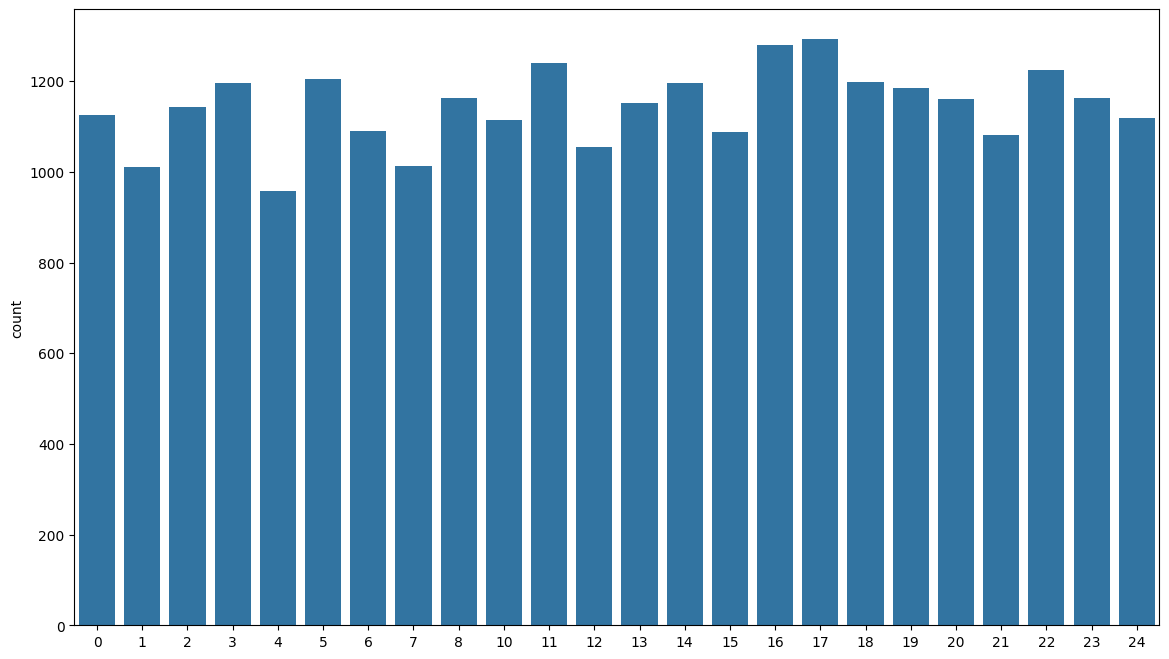

In [30]:
# Plot graph of labels
labels = train_df["label"].values
plt.figure(figsize = (14,8))
sns.countplot(x=labels)

In [31]:
train_df.shape, test_df.shape

((27455, 785), (7172, 785))

In [32]:
# # Drop label columns from data sets
# x_train = train_df.drop(["label"],axis=1)
# x_test = test_df.drop(["label"],axis=1)

# y_train = train_df['label']
# y_test = test_df['label']

# del train_df['label']
# del test_df['label']

In [33]:
# # Greyscale normalization
# x_train = x_train/255
# x_test = x_test/255

# # Reshape data from 1-D to 3-D so it will be accepted by the CNN model
# x_train = x_train.values.reshape(-1,28,28,1)
# x_test = x_test.values.reshape(-1,28,28,1)

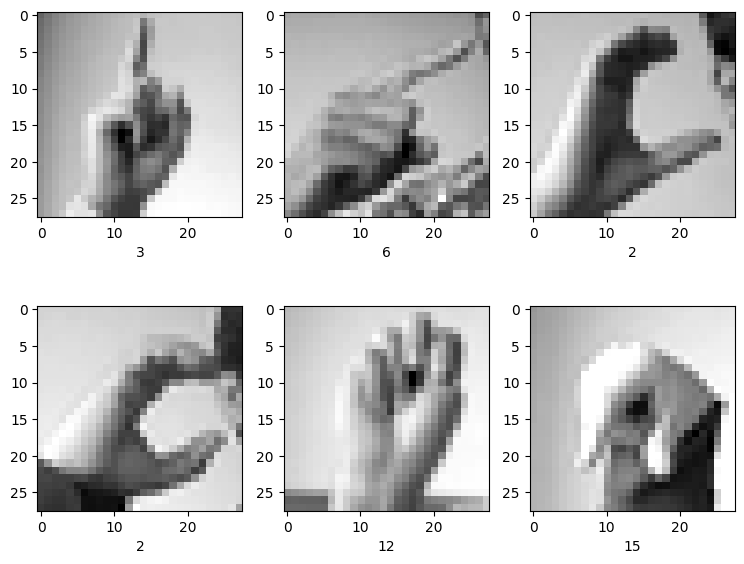

In [34]:
# Check out some sample images of what we've done so far
plt.figure(figsize=(9,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.xlabel(np.argmax(y_train[i]))

plt.show()

In [35]:
# # Convert integer labels into binary form using Label Binarizer
# from sklearn.preprocessing import LabelBinarizer
# label_binarizer = LabelBinarizer()
# y_train = label_binarizer.fit_transform(y_train)
# y_test = label_binarizer.fit_transform(y_test)

In [36]:
# Train validation split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("x_train shape",x_train.shape)
print("x_test shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (21964, 28, 28, 1)
x_test shape (5491, 28, 28, 1)
y_train shape (21964, 24)
y_test shape (5491, 24)


In [37]:
# Augment data to prevent overfitting/bias
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # Set input mean to 0 over the dataset
        featurewise_center=False,
        # Set each sample mean to 0
        samplewise_center=False,
        # Divide inputs by std of the dataset
        featurewise_std_normalization=False,
        # Divide each input by its std
        samplewise_std_normalization=False,
        # Apply ZCA whitening
        zca_whitening=False,
        # Randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=10,
        # Randomly zoom image
        zoom_range = 0.1,
        # Randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # Randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        # Randomly flip images
        horizontal_flip=False,
        # Randomly flip images
        vertical_flip=False)

datagen.fit(x_train)

In [38]:
# Reduce learning rate when a metric has stopped improving so the model will move on
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [39]:
model = Sequential()

model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Flatten feature maps into a one-dimensional vector to be fed into the fully connected layers
model.add(Flatten())

model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

#Use Adam optimization algorithm
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,049 (1.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

In [40]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,
                    epochs = 20 ,
                    validation_data = (x_test, y_test) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/20


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.4202 - loss: 1.9794 - val_accuracy: 0.0485 - val_loss: 4.3525 - learning_rate: 0.0010
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.8868 - loss: 0.3438 - val_accuracy: 0.0672 - val_loss: 6.0617 - learning_rate: 0.0010
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.9510 - loss: 0.1476 - val_accuracy: 0.8321 - val_loss: 0.5075 - learning_rate: 0.0010
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.9745 - loss: 0.0844 - val_accuracy: 0.9403 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.9779 - loss: 0.0658 - val_accuracy: 0.8190 - val_loss: 0.6228 - learning_rate: 0.0010
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.9830 - loss: 0.0502 - val_accuracy: 0.9771 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.9881 - loss:

KeyboardInterrupt: 

In [ ]:
print("Accuracy of model:" , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9973 - loss: 0.0093
Accuracy of model: 99.8047947883606 %


In [18]:
## Use to save current model
# import joblib
# joblib.dump(model, 'sign_vision_model.joblib')

## Use to load the previous model
# joblib.load

In [ ]:
# Generate predictions for the test set
predictions = model.predict(x_test)
model.save('model.h5')

# Convert probabilities back to class labels
y_pred = np.argmax(predictions, axis=1)

y_true = np.argmax(y_test, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Precision: 0.9975194201569361, Recall: 0.9977543923322196, F1 Score: 0.9975964195517046


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
specificity_list = []

# Calculate specificity for each class
for i in range(len(cm)):
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)

# Specificity value for each class
for index, specificity in enumerate(specificity_list):
    print(f"Specificity for class {index}: {specificity}")

Specificity for class 0: 1.0
Specificity for class 1: 0.9998516320474777
Specificity for class 2: 1.0
Specificity for class 3: 1.0
Specificity for class 4: 1.0
Specificity for class 5: 0.9992779783393502
Specificity for class 6: 1.0
Specificity for class 7: 1.0
Specificity for class 8: 1.0
Specificity for class 9: 1.0
Specificity for class 10: 1.0
Specificity for class 11: 1.0
Specificity for class 12: 1.0
Specificity for class 13: 1.0
Specificity for class 14: 1.0
Specificity for class 15: 1.0
Specificity for class 16: 1.0
Specificity for class 17: 1.0
Specificity for class 18: 1.0
Specificity for class 19: 1.0
Specificity for class 20: 1.0
Specificity for class 21: 0.9988515647430376
Specificity for class 22: 1.0
Specificity for class 23: 1.0
